## 1. package import 

In [1]:
from zipline import run_algorithm
from zipline.api import order_target_percent, symbol, schedule_function,date_rules, time_rules
from datetime import datetime
import pyfolio as pf

import pandas as pd


## 2. func

In [2]:
def initialize(context):
    # Which stocks to trade
    dji = [
        "AAPL",
        "AXP",
        "BA",
        "CAT",
        "CSCO",
        "CVX",
        "DIS",
        "DWDP",
        "GS",
        "HD",
        "IBM",
        "INTC",
        "JNJ",
        "JPM",
        "KO",
        "MCD",
        "MMM",
        "MRK",
        "MSFT",
        "NKE",
        "PFE",
        "PG",
        "TRV",
        "UNH",
        "UTX",
        "V",
        "VZ",
        "WBA",
        "WMT",
        "XOM",  
    ]
    
    # 티커로부터 심볼 리스트 만들기
    context.universe = [symbol(s) for s in dji]
    # 히스토리 윈도우
    context.history_window = 20  # 약 한달 간, 20일
    #포트폴리오 크기
    context.stocks_to_hold = 10  #홀드(매수)하는 주식 수
    #한 달에 한 번만 거래 함
    schedule_function(handle_data, date_rules.month_start(), time_rules.market_close())

In [3]:
def month_perf(ts):
    perf = (ts[-1]/ ts[0] - 1)
    return perf

In [4]:
def handle_data(context, data):
    hist = data.history(context.universe, "close", context.history_window, "1d")
    perf_table = hist.apply(month_perf).sort_values(ascending=False) # 가장 높은 성과를 가지는 포트폴리오 순서로 정렬
    buy_list= perf_table[:context.stocks_to_hold]  #홀드(매수) 주식 계획에 따라 매수 리스트 생성
    the_rest = perf_table[context.stocks_to_hold:]  #홀드 이외에는 버림
    
    for stock, perf in buy_list.iteritems():  #홀드(매수) 주식 계획에 따라 포트 폴리오 비중 조정
        stock_weight = 1 / context.stocks_to_hold
        if data.can_trade(stock):order_target_percent(stock, stock_weight)
            
    for stock, perf in the_rest.iteritems(): #홀드(매수) 주식 계획에 따라 포트 폴리오 비중 조정
        if data.can_trade(stock): order_target_percent(stock, 0.0)

In [5]:
def analyze(context, perf):
    returns, postions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf) #수익률, 포지션, 거래 반환
    pf.create_returns_tear_sheet(returns, benchmark_rets=None)
    

## 3. Run

In [6]:
start = pd.Timestamp('2003-1-1', tz='utc')
end = pd.Timestamp('2017-12-31', tz='utc')

## 전략의 성과
### 핵심 비율(key ratio)
- 연간 수익률: 일반적으로 높으 수익률이 낮은 수익률보다 낫지만, 수익률 만으로는 맥락을 알 수 없다.
- 연간 변동성(YV), 샤프비율(SR), 최대 손실낙폭(MDD): 이러한 수치들은 변동성과 하향 위험을 고려한다.
- 현실에서 연간 15% 이상의 수익률을 보일 가능성은 낮고, 샤프 비율이 1%를 넘을 가능성을 낮으며 장기 수익률의 세 배의 최대 손실폭을 보일 수도 있다. 이를 넘어서는 백테스트는 문제가 있다고 볼 수 있고, 현실에서 달성할 수 있는 수치가 아니다.

### 손실 테이블 (drawdown table)
- 상위 5개 손실 기간 (drawdown period), 손실 퍼센트(percent loss), 날짜(dates) 및 회복 시간(recovery time)을 보여준다.

Start date,2003-01-02
End date,2017-12-29
Total months,179
,Backtest
Annual return,9.606%
Cumulative returns,295.256%
Annual volatility,18.176%
Sharpe ratio,0.60
Calmar ratio,0.17
Stability,0.78
Max drawdown,-58.17%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,58.17,2007-10-31,2009-03-09,2013-03-22,1408
1,12.98,2015-07-16,2015-08-25,2016-03-11,172
2,11.09,2004-03-05,2004-08-06,2004-10-06,154
3,10.16,2007-07-19,2007-08-16,2007-10-29,73
4,10.00,2003-01-06,2003-03-11,2003-03-21,55


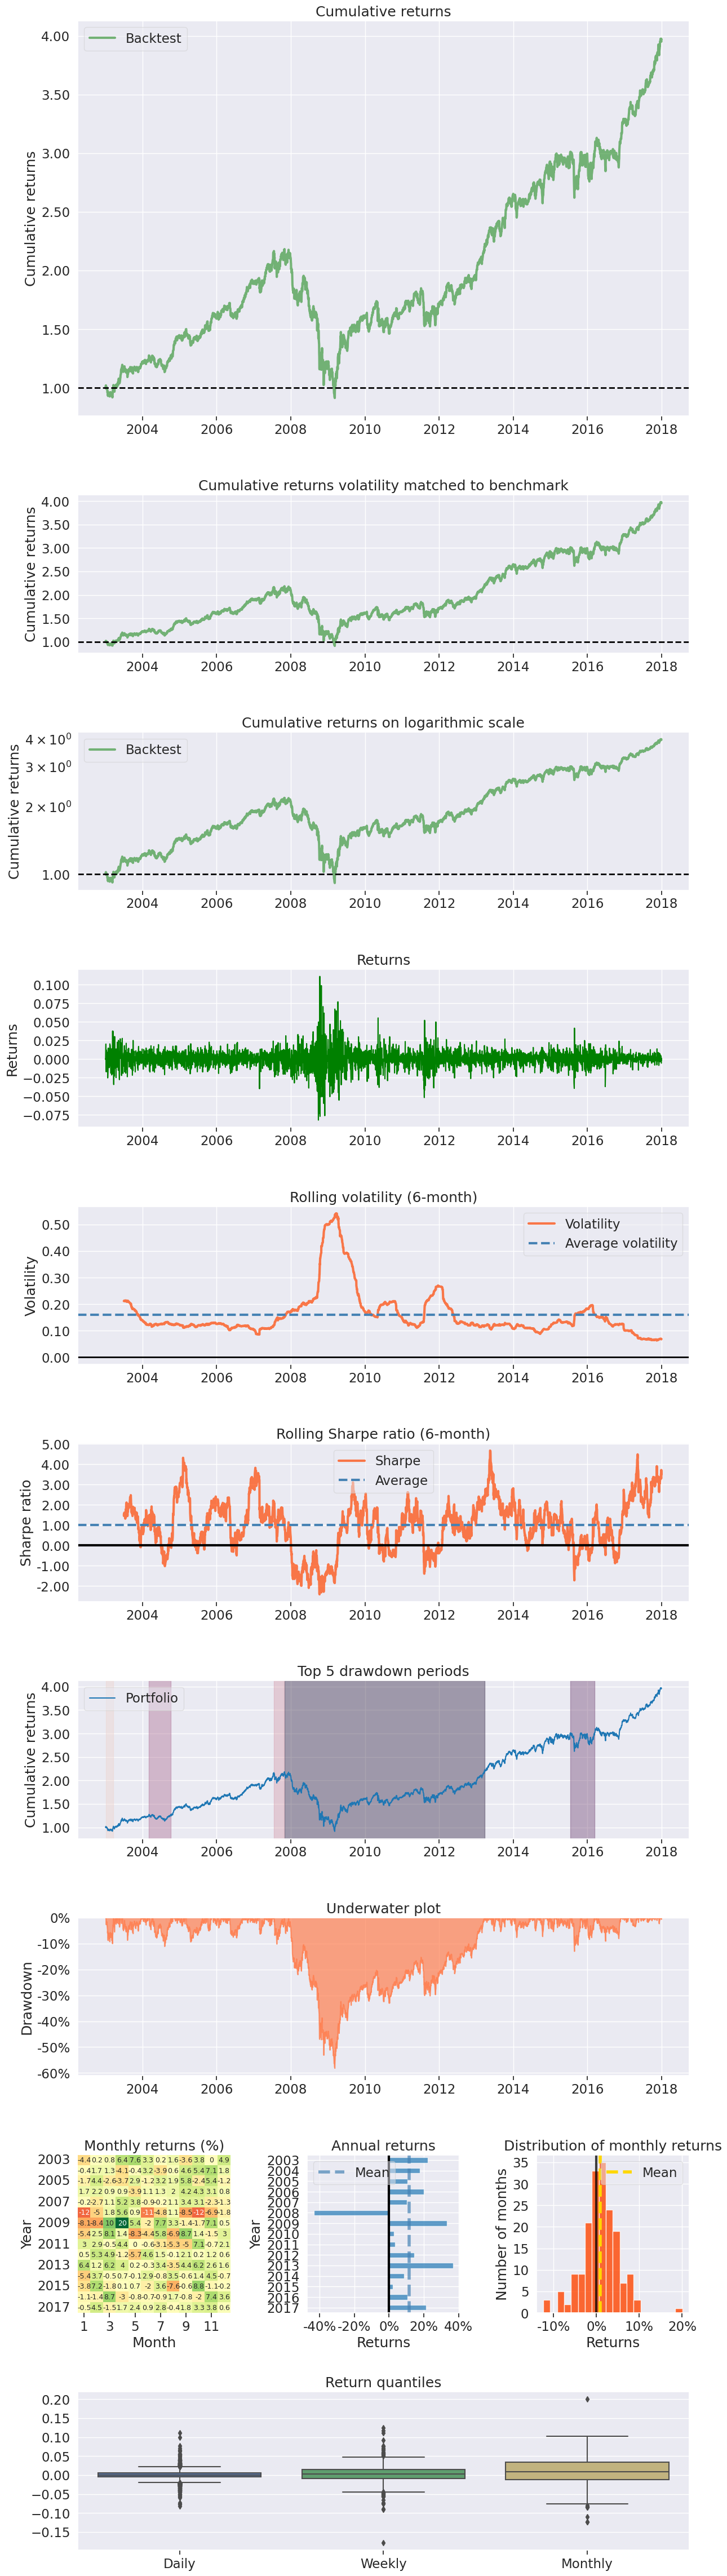

In [7]:
result = run_algorithm(
        start=start,
        end=end,
        initialize=initialize,
        analyze=analyze,
        capital_base=10000,
        data_frequency='daily',
        bundle='quandl')

## result의 데이터 종류

In [26]:
result.head()

,period_open,period_close,portfolio_value,long_value,shorts_count,longs_count,starting_value,ending_cash,starting_cash,orders,...,treasury_period_return,trading_days,period_label,algo_volatility,benchmark_period_return,benchmark_volatility,algorithm_period_return,alpha,beta,sharpe
2003-01-02 00:00:00+00:00,2003-01-02 14:31:00+00:00,2003-01-02 21:00:00+00:00,10000.000000,0.00,0,0,0.00,10000.000000,10000.000000,"[{'id': '1133553e0a2e411581f55ccf02959b22', 'd...",...,0.0,1,2003-01,NaN,0.0,NaN,0.000000,None,None,NaN
2003-01-03 00:00:00+00:00,2003-01-03 14:31:00+00:00,2003-01-03 21:00:00+00:00,9994.870225,9793.55,0,10,0.00,201.320225,10000.000000,"[{'id': '1133553e0a2e411581f55ccf02959b22', 'd...",...,0.0,2,2003-01,0.005758,0.0,0.0,-0.000513,None,None,-11.224972
2003-01-06 00:00:00+00:00,2003-01-06 14:31:00+00:00,2003-01-06 21:00:00+00:00,10197.730225,9996.41,0,10,9793.55,201.320225,201.320225,[],...,0.0,3,2003-01,0.188414,0.0,0.0,0.019773,None,None,8.819963
2003-01-07 00:00:00+00:00,2003-01-07 14:31:00+00:00,2003-01-07 21:00:00+00:00,10095.990225,9894.67,0,10,9996.41,201.320225,201.320225,[],...,0.0,4,2003-01,0.202403,0.0,0.0,0.009599,None,None,3.052444
2003-01-08 00:00:00+00:00,2003-01-08 14:31:00+00:00,2003-01-08 21:00:00+00:00,9924.360225,9723.04,0,10,9894.67,201.320225,201.320225,[],...,0.0,5,2003-01,0.223147,0.0,0.0,-0.007564,None,None,-1.624639


In [27]:
for column in result:
    print(column)

period_open
period_close
portfolio_value
long_value
shorts_count
longs_count
starting_value
ending_cash
starting_cash
orders
ending_value
transactions
short_value
starting_exposure
positions
long_exposure
short_exposure
ending_exposure
gross_leverage
pnl
net_leverage
returns
capital_used
sortino
max_drawdown
max_leverage
excess_return
treasury_period_return
trading_days
period_label
algo_volatility
benchmark_period_return
benchmark_volatility
algorithm_period_return
alpha
beta
sharpe


### 특정 일의 포지션 스냅샷

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

In [29]:
day = '2009-03-17'

In [36]:
port_value = result.loc[day,'portfolio_value']
day_positions = result.loc[day,'positions']

In [37]:
df = pd.DataFrame(columns=['value', 'pnl'])

In [44]:
for pos in day_positions:
    ticker = pos['sid'].symbol 
    df.loc[ticker,'value'] = pos['amount'] * pos['last_sale_price']
    df.loc[ticker,'pnl'] = df.loc[ticker,'value'] - (pos['amount'] * pos['cost_basis'])
    
# 현금 포지션 추가
df.loc['cash', ['value','pnl']] = [(port_value - df['value'].sum()), 0]    
    

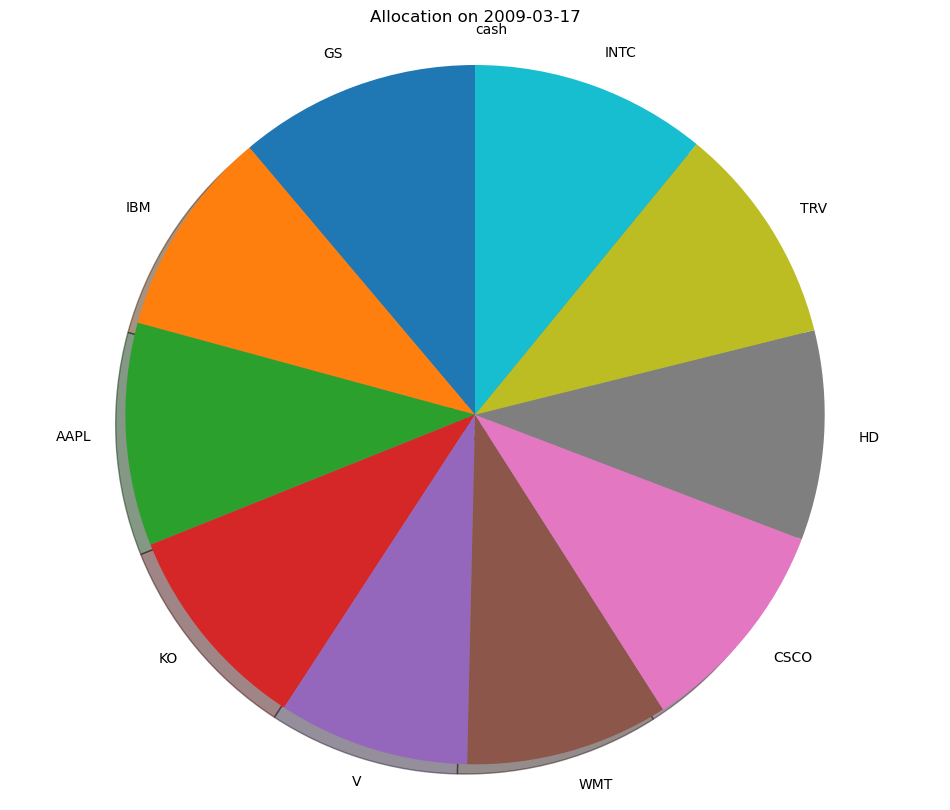

In [46]:
# Make pie chart for allocations
fig, ax1 = plt.subplots(figsize=[12, 10])
ax1.pie(df['value'], labels=df.index, shadow=True, startangle=90)
ax1.axis('equal')
ax1.set_title('Allocation on {}'.format(day))
plt.show()

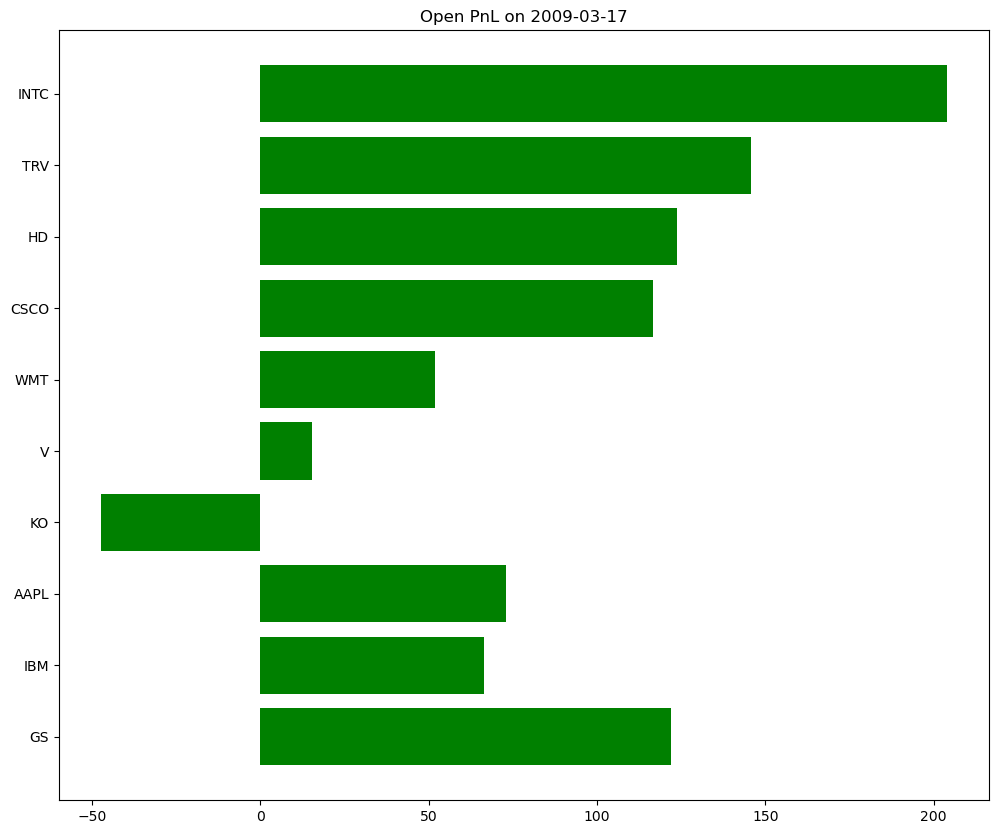

In [47]:
# Make bar chart for open PnL
fig, ax1 = plt.subplots(figsize=[12, 10])
pnl_df = df.drop('cash')
ax1.barh( pnl_df.index, pnl_df['pnl'],  align='center', color='green', ecolor='black')
ax1.set_title('Open PnL on {}'.format(day))
plt.show()

### 시계열 분석

In [48]:
import numpy as np
import pandas as pd

from matplotlib import pyplot, rc, ticker

In [50]:
font = {'family': 'eurostile',
        'weight': 'normal',
         'size': 16}
rc('font', **font)

calc_window = 126 # 반년의 거래 일 수
year_length = 252 # 1년의 거래 일 수

# 필요한 열을 복사 한다. ('portfolio_value', 'gross_leverage')
df = result.copy().filter(items=['portfolio_value', 'gross_leverage'])

# 연간 수익률 계산
def ann_ret(ts):
    return np.power((ts[-1]/ts[0]), (year_length/len(ts)))-1

# MDD 계산
def dd(ts):
    return np.min(ts / np.maximum.accumulate(ts)) - 1

rolling_window = result.portfolio_value.rolling(calc_window)

df['annualized'] = rolling_window.apply(ann_ret)
df['drawdown'] = rolling_window.apply(dd)

df.dropna(inplace=True)



findfont: Font family ['eurostile'] not found. Falling back to DejaVu Sans.
findfont: Font family ['eurostile'] not found. Falling back to DejaVu Sans.


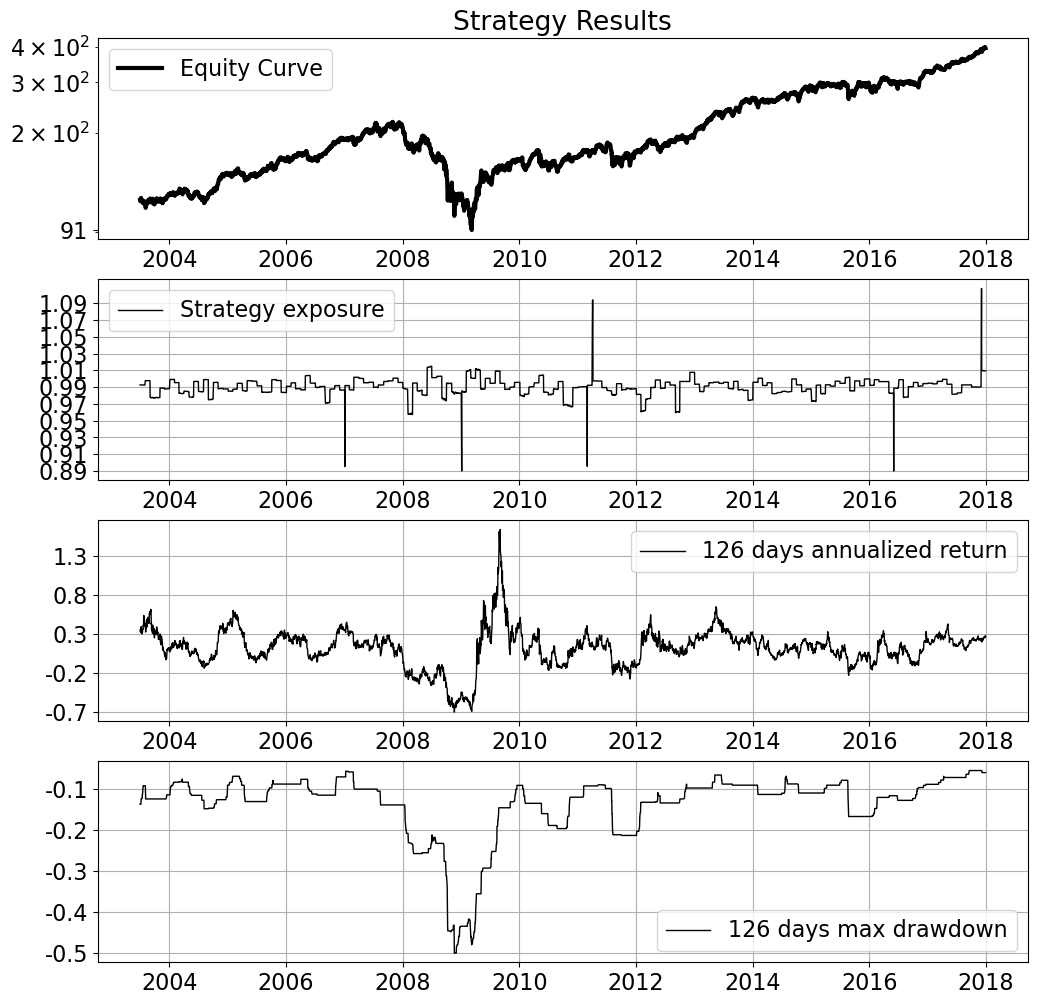

In [51]:

# Make a figure
fig = plt.figure(figsize=(12, 12))

# Make the base lower, just to make the graph easier to read
df['portfolio_value'] /= 100

# First chart
ax = fig.add_subplot(411)
ax.set_title('Strategy Results')
ax.plot(df['portfolio_value'], 
        linestyle='-', 
        color='black',
        label='Equity Curve', linewidth=3.0)

# Set log scale
ax.set_yscale('log') 

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['portfolio_value'].min(), df['portfolio_value'].max(), 500 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))

# Add legend and grid
ax.legend()
ax.grid(False)

# Second chart
ax = fig.add_subplot(412)
ax.plot(df['gross_leverage'], 
        label='Strategy exposure'.format(calc_window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['gross_leverage'].min(), df['gross_leverage'].max(), 0.02 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Add legend and grid
ax.legend()
ax.grid(True)

# Third chart
ax = fig.add_subplot(413)
ax.plot(df['annualized'], 
        label='{} days annualized return'.format(calc_window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['annualized'].min(), df['annualized'].max(), 0.5 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

# Add legend and grid
ax.legend()
ax.grid(True)

# Fourth chart
ax = fig.add_subplot(414)
ax.plot(df['drawdown'], 
        label='{} days max drawdown'.format(calc_window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['drawdown'].min(), df['drawdown'].max(), 0.1 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

# Add legend and grid
ax.legend()
ax.grid(True)


---